In [1]:
import sys
import os
import time
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from scipy import signal
from typing import List

sys.path.insert(0, os.path.abspath("../cli"))
from simulation.sonar import Sonar
from simulation.utils import CircleBottom, run_beam, positions_line
from simulation.sources import SineSource
from examples.seismic import plot_velocity, Receiver

plt.rcParams['figure.figsize'] = (5, 5)
sys.stderr = open(os.devnull, 'w')

In [2]:
def get_ideal_signal(domain_size, f0, v_env, sd, ns, posy, angle,dt, plot = False):
    max_distance = domain_size[1]
    t_end = max_distance / v_env
    s = Sonar(domain_size, f0, v_env, CircleBottom(domain_size[0] / 2, domain_size[1] / 2, domain_size[1] / 2), dt = dt, tn=t_end)
    src_coord = np.array([(domain_size[0] - sd * ns) / 2, domain_size[1] / 2]) + positions_line(
        stop_x=ns * sd, posy=sd, n=ns
    )
    src = SineSource(
        name="src",
        grid=s.model.grid,
        npoint=ns,
        f0=f0,
        time_range=s.time_range,
        coordinates_data=src_coord,
    )
    distance = domain_size[1] / 2 * posy
    rec_x = domain_size[0] / 2 - np.cos(np.deg2rad(angle)) * distance
    rec_y = domain_size[1] / 2 + np.sin(np.deg2rad(angle)) * distance
    rec = Receiver(
        name="rec",
        grid=s.model.grid,
        time_range=s.time_range,
        npoint=1,
        coordinates=np.array([[rec_x, rec_y]]),
    )
    s.set_source(src, rec)
    s.finalize(snapshot_delay=.1)
    print(f"Signal length: {s.src.signal_packet.shape[0]}")
    recording = run_beam(s.src, s.rec, s.op, s.u, sd, s.time_range, s.model.critical_dt, angle, v_env)
    if plot:
        plot_velocity(s.model, source=src.coordinates.data, receiver=rec.coordinates.data)
        plt.plot(recording)
    return recording[:, 0], s.usave.data

In [3]:
def plot_snapshot_and_signal(
    snap: npt.NDArray,
    recording: npt.NDArray,
    model,
    outfile,
):
    fig, ax = plt.subplots(
        2, 1, figsize=(10, 15), gridspec_kw={"width_ratios": [1], "height_ratios": [2, 1]}
    )
    snap_step = int(recording.shape[0] / snap.shape[0])
    ax[0].imshow(
        np.transpose(model.vp.data),
        cmap="viridis",
        vmin=np.min(model.vp.data),
        vmax=np.max(model.vp.data),
    )
    ampl_limit = max(abs(np.min(snap)), abs(np.max(snap))) / 4
    matrice = ax[0].imshow(
        snap[0, :, :].T, vmin=-ampl_limit, vmax=ampl_limit, cmap="seismic", alpha=0.8
    )

    (aline,) = ax[1].plot(recording[:1])
    ax[1].set_ylim(1.1 * np.min(recording), 1.1 * np.max(recording))
    ax[1].set_xlim(0, len(recording))

    def update(i):
        matrice.set_array(snap[i, :, :].T)
        aline.set_data(np.arange(i * snap_step), recording[:i * snap_step])
        return (matrice,aline)


    ani = animation.FuncAnimation(
        fig, update, frames=snap.shape[0], interval=300, blit=True
    )
    ani.save(outfile)
    plt.close(ani._fig)
    

In [4]:
v_env = 1.5
ns = 128
domain_size = (10, 10)
source_distance = 0.002
cy = (ns - 1) / 2 * source_distance + source_distance
r = 2.8

f0 = 100
sonar = Sonar(domain_size, f0, v_env, CircleBottom(domain_size[0] / 2, domain_size[1] / 2, domain_size[1] / 2))
sonar.set_source(source_distance=source_distance, ns=ns)
sonar.finalize()
dt = sonar.model.critical_dt

Operator `initdamp` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s
Operator `initdamp` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s
Operator `Kernel` ran in 0.12 s


Signal length: 1694


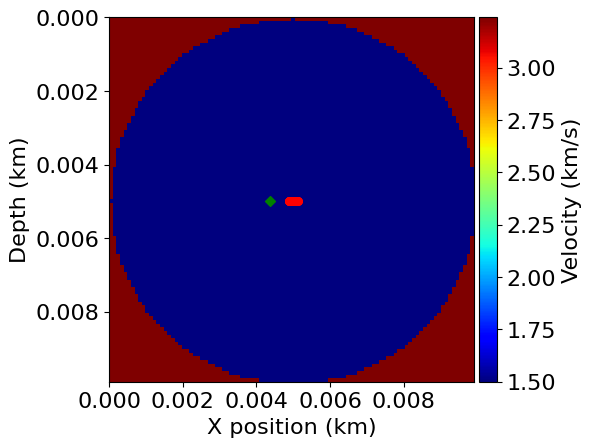

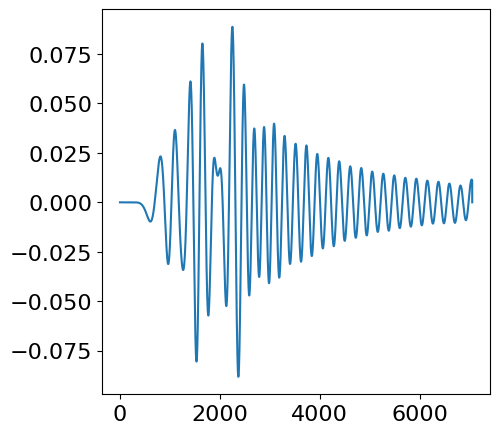

In [13]:
_, _ = get_ideal_signal(domain_size, 100, v_env, source_distance, ns, cy, 45, dt, plot=True)

Running 5 0.2 45
Signal length: 1694
Time: 1.6182243824005127
Running 5 0.35 45
Signal length: 1694
Time: 1.1465823650360107
Running 5 0.5 45
Signal length: 1694
Time: 1.105309247970581
Running 5 0.65 45
Signal length: 1694
Time: 1.6308016777038574
Running 5 0.8 45
Signal length: 1694
Time: 1.1493234634399414
Running 10 0.2 45
Signal length: 847
Time: 1.2559938430786133
Running 10 0.35 45
Signal length: 847
Time: 1.4399824142456055
Running 10 0.5 45
Signal length: 847
Time: 1.267155647277832
Running 10 0.65 45
Signal length: 847
Time: 1.2247674465179443
Running 10 0.8 45
Signal length: 847
Time: 1.5098252296447754
Running 50 0.2 45
Signal length: 170
Time: 14.390990257263184
Running 50 0.35 45
Signal length: 170
Time: 14.752567529678345
Running 50 0.5 45
Signal length: 170
Time: 14.395525932312012
Running 50 0.65 45
Signal length: 170
Time: 13.954451560974121
Running 50 0.8 45
Signal length: 170
Time: 14.075467824935913
Running 100 0.2 45
Signal length: 85
Time: 54.072465896606445
Runn

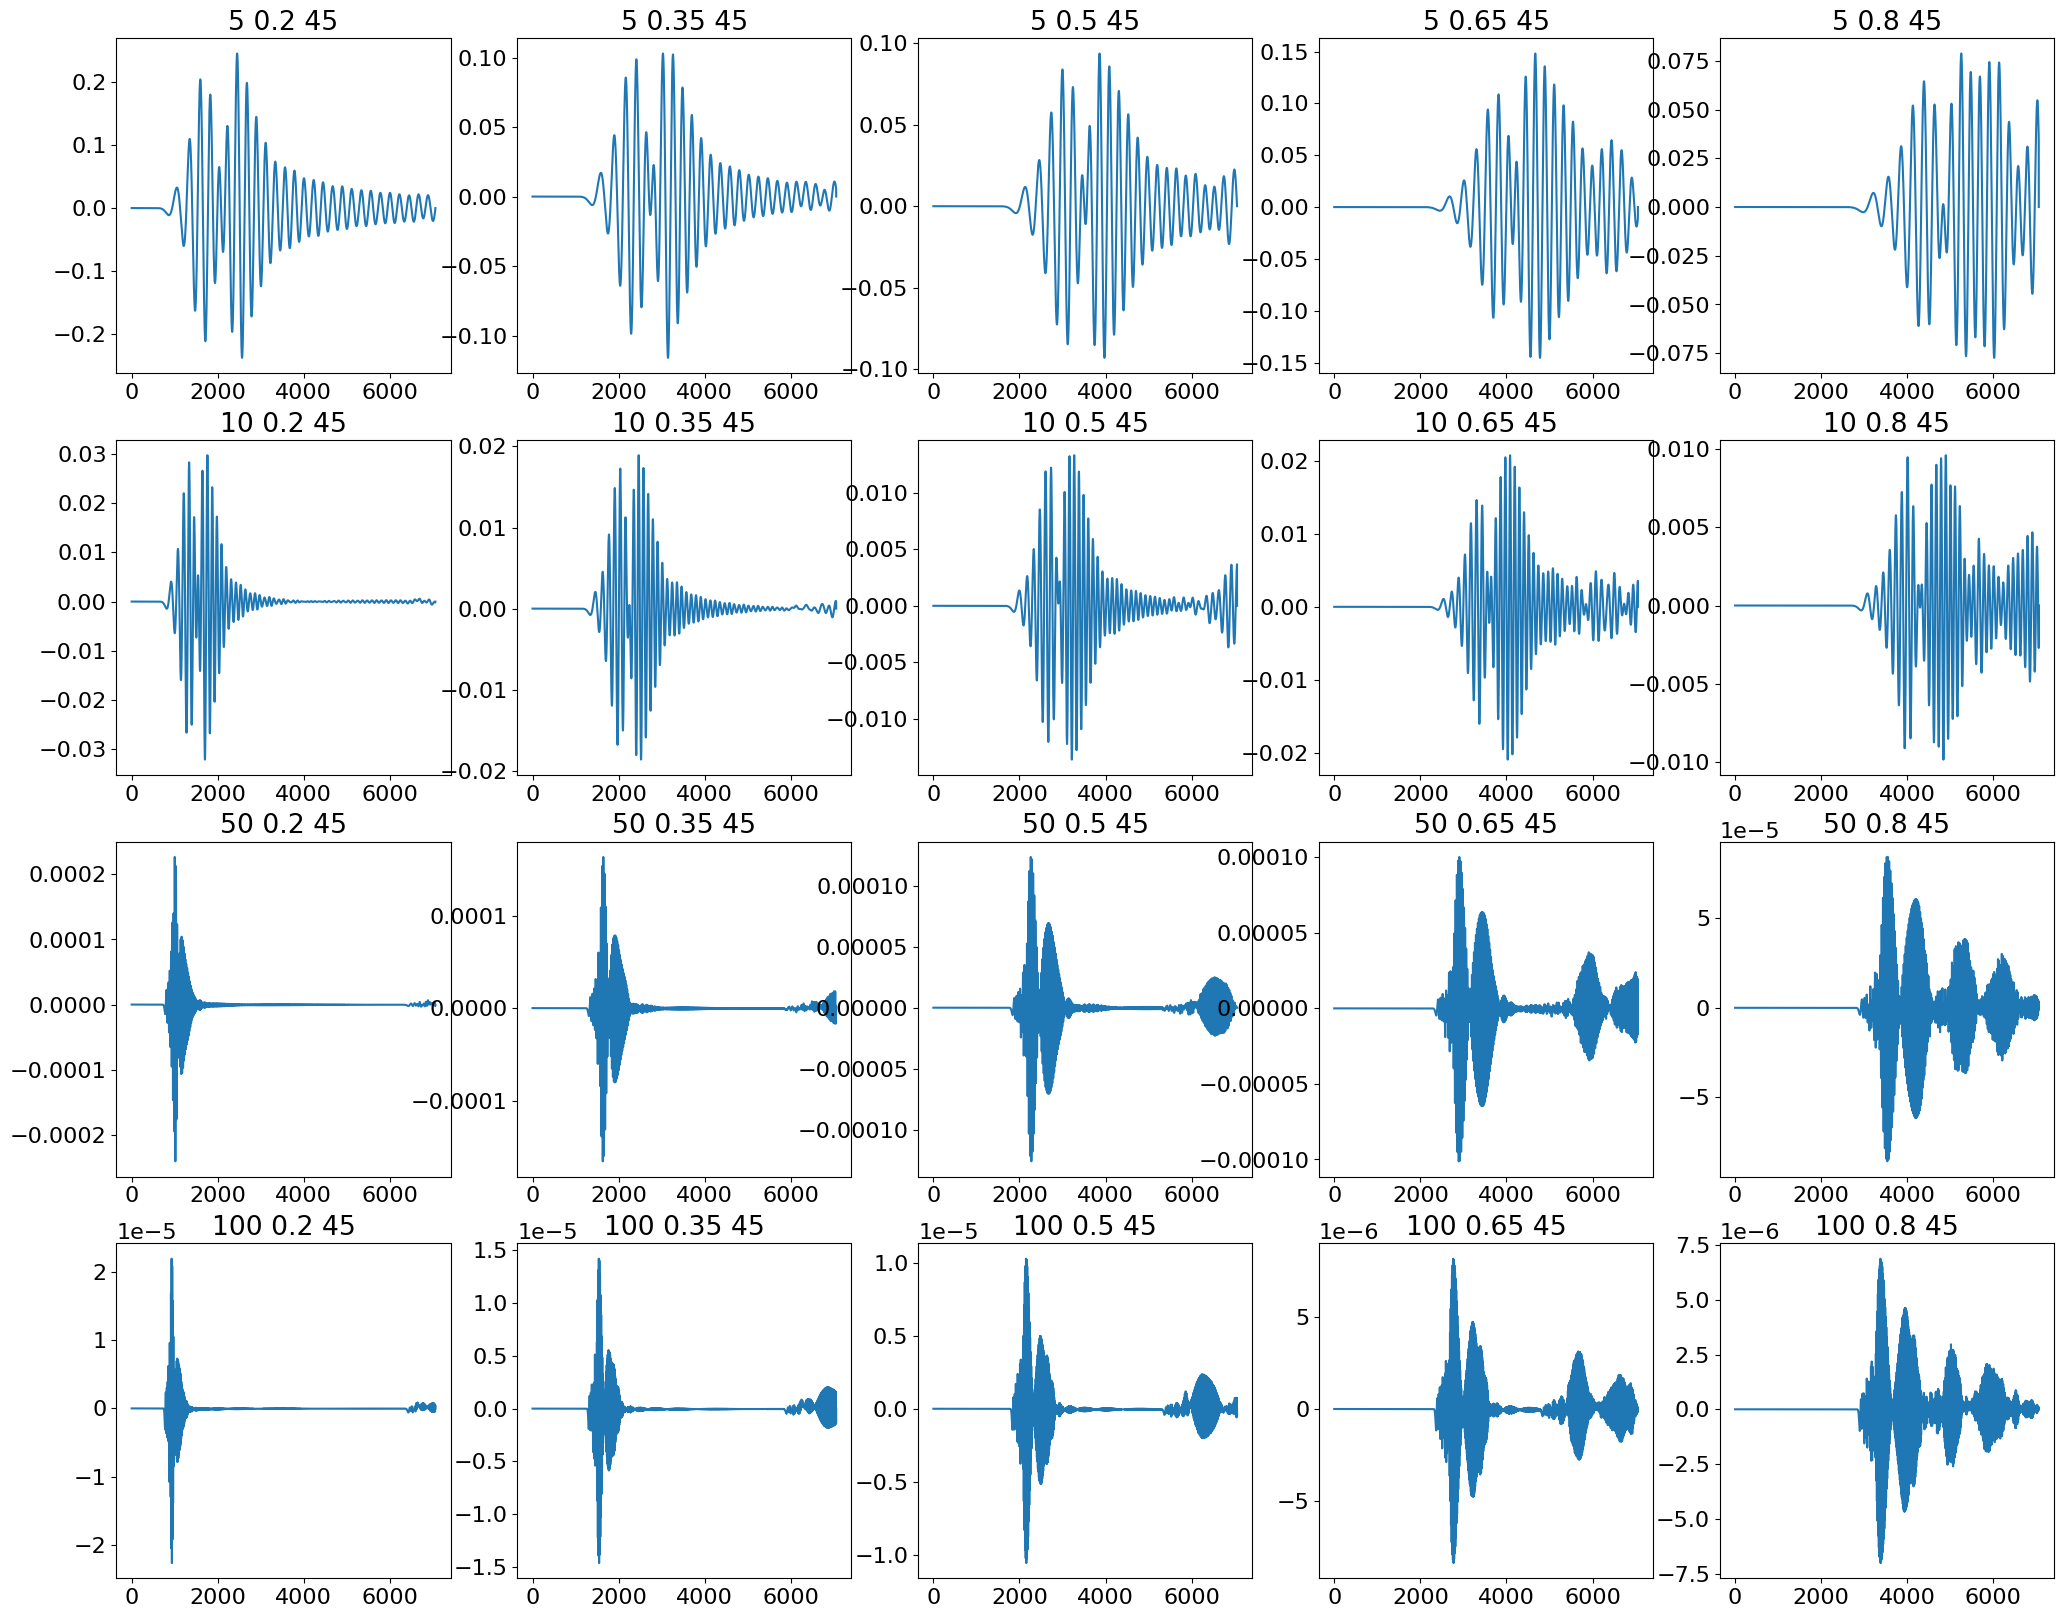

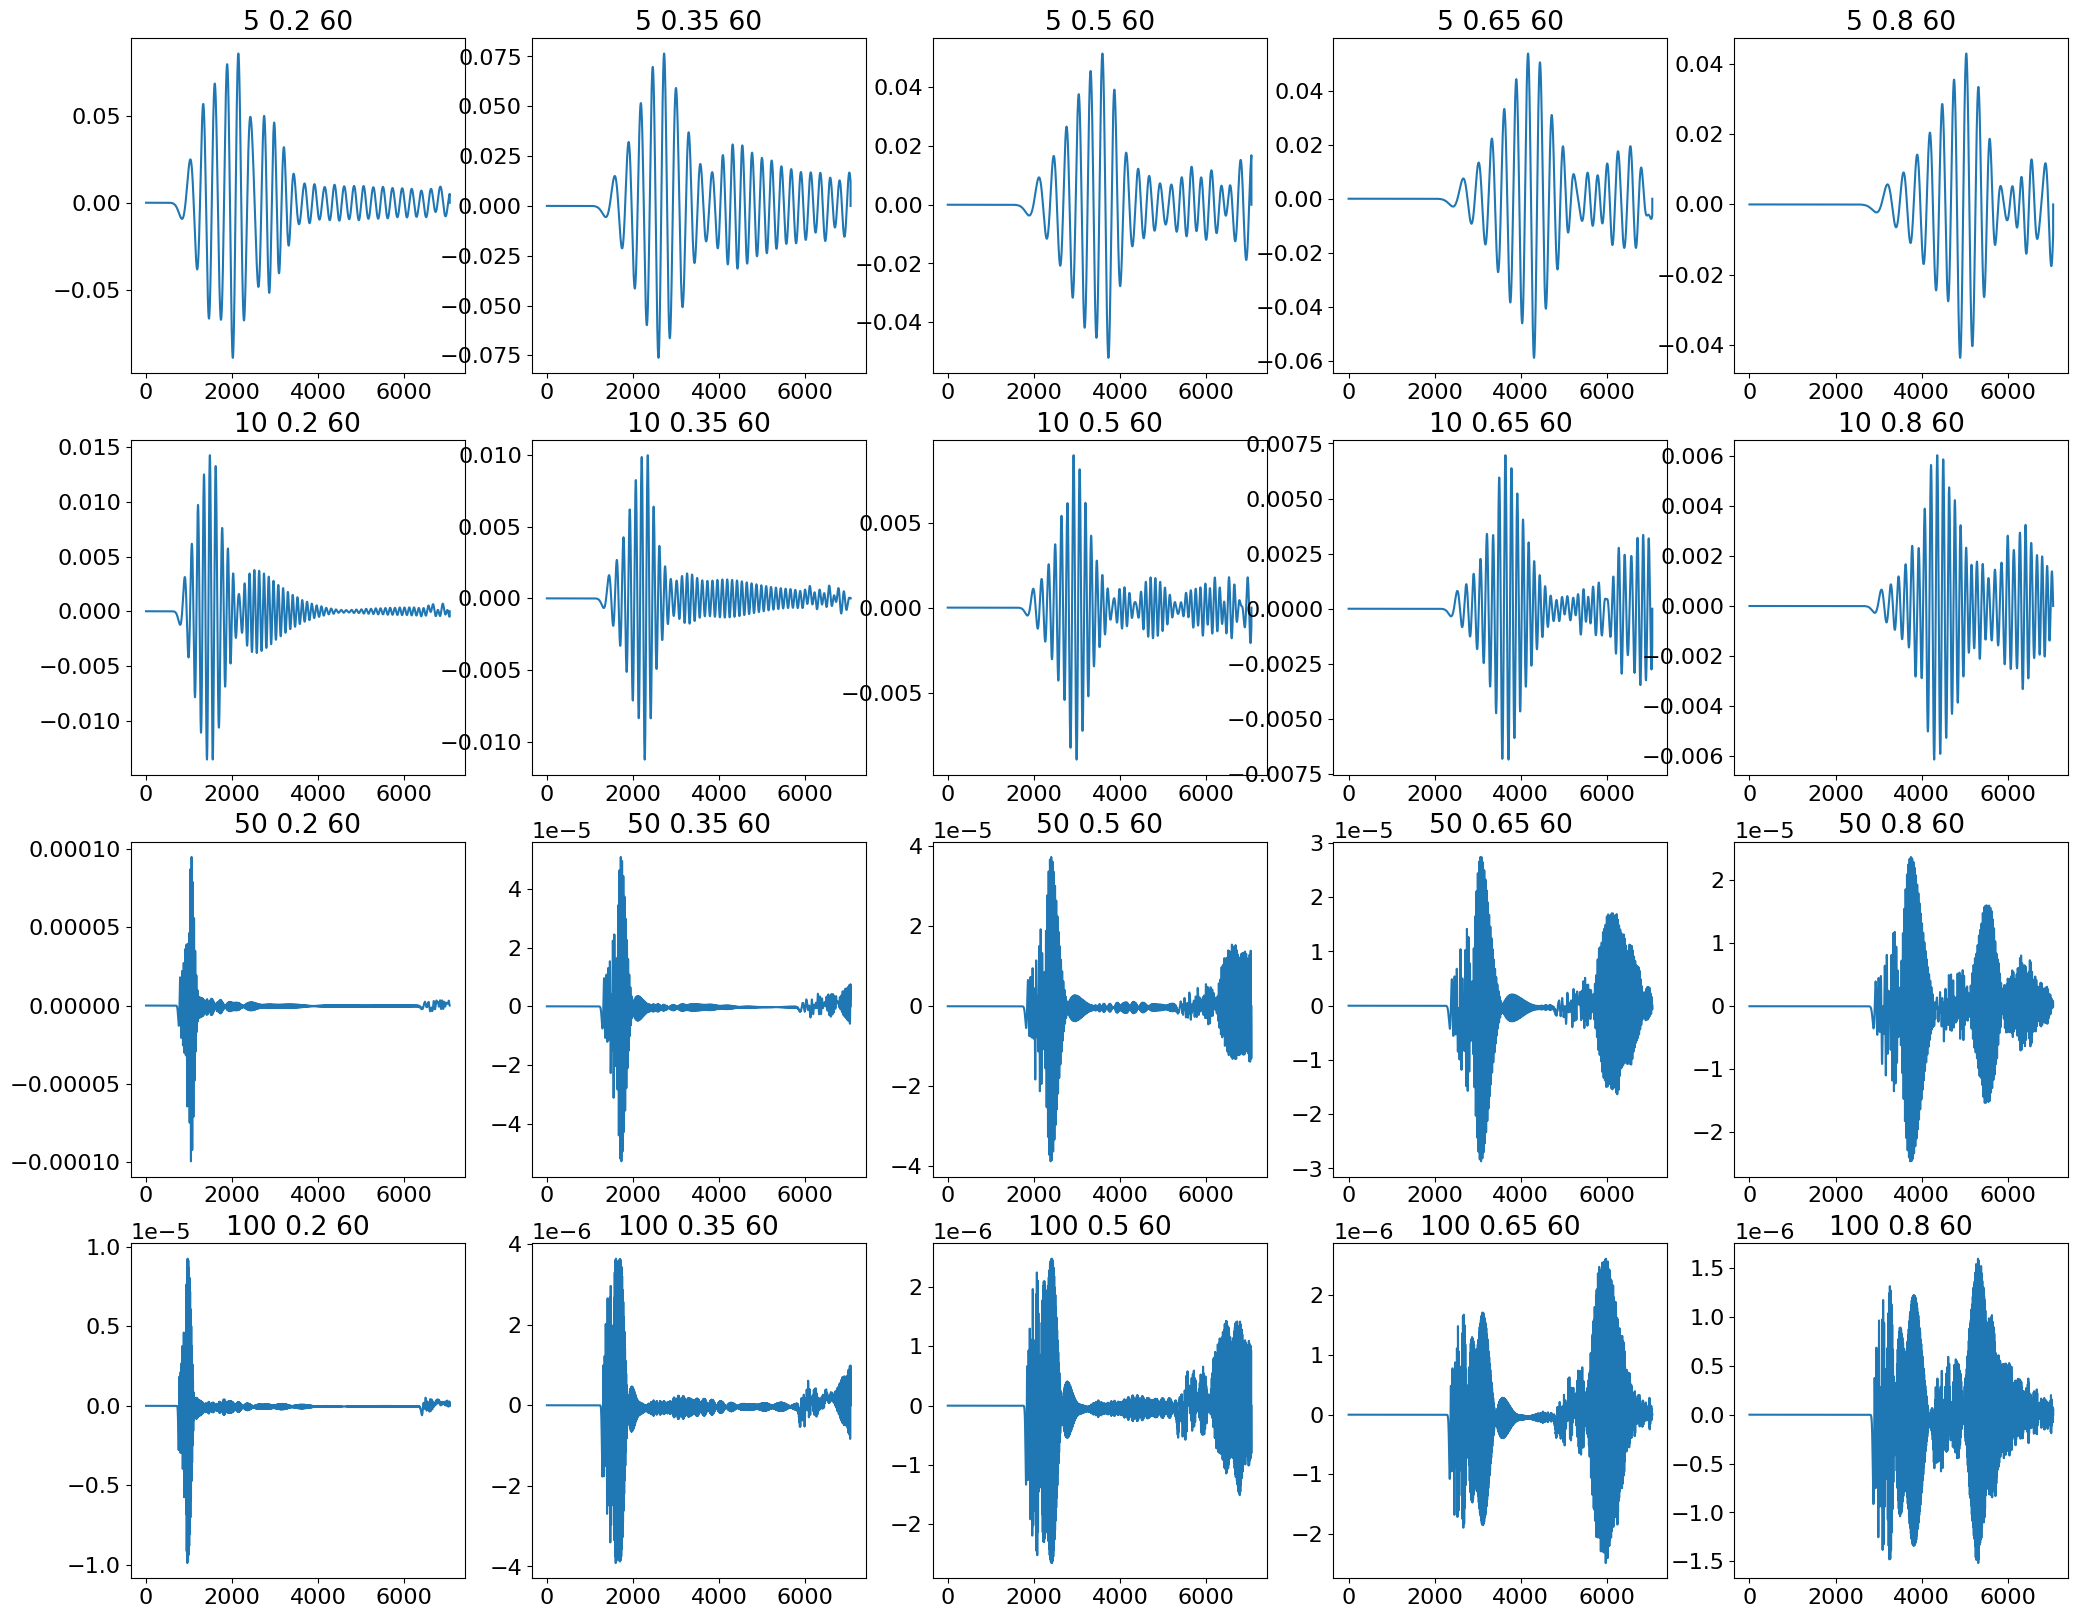

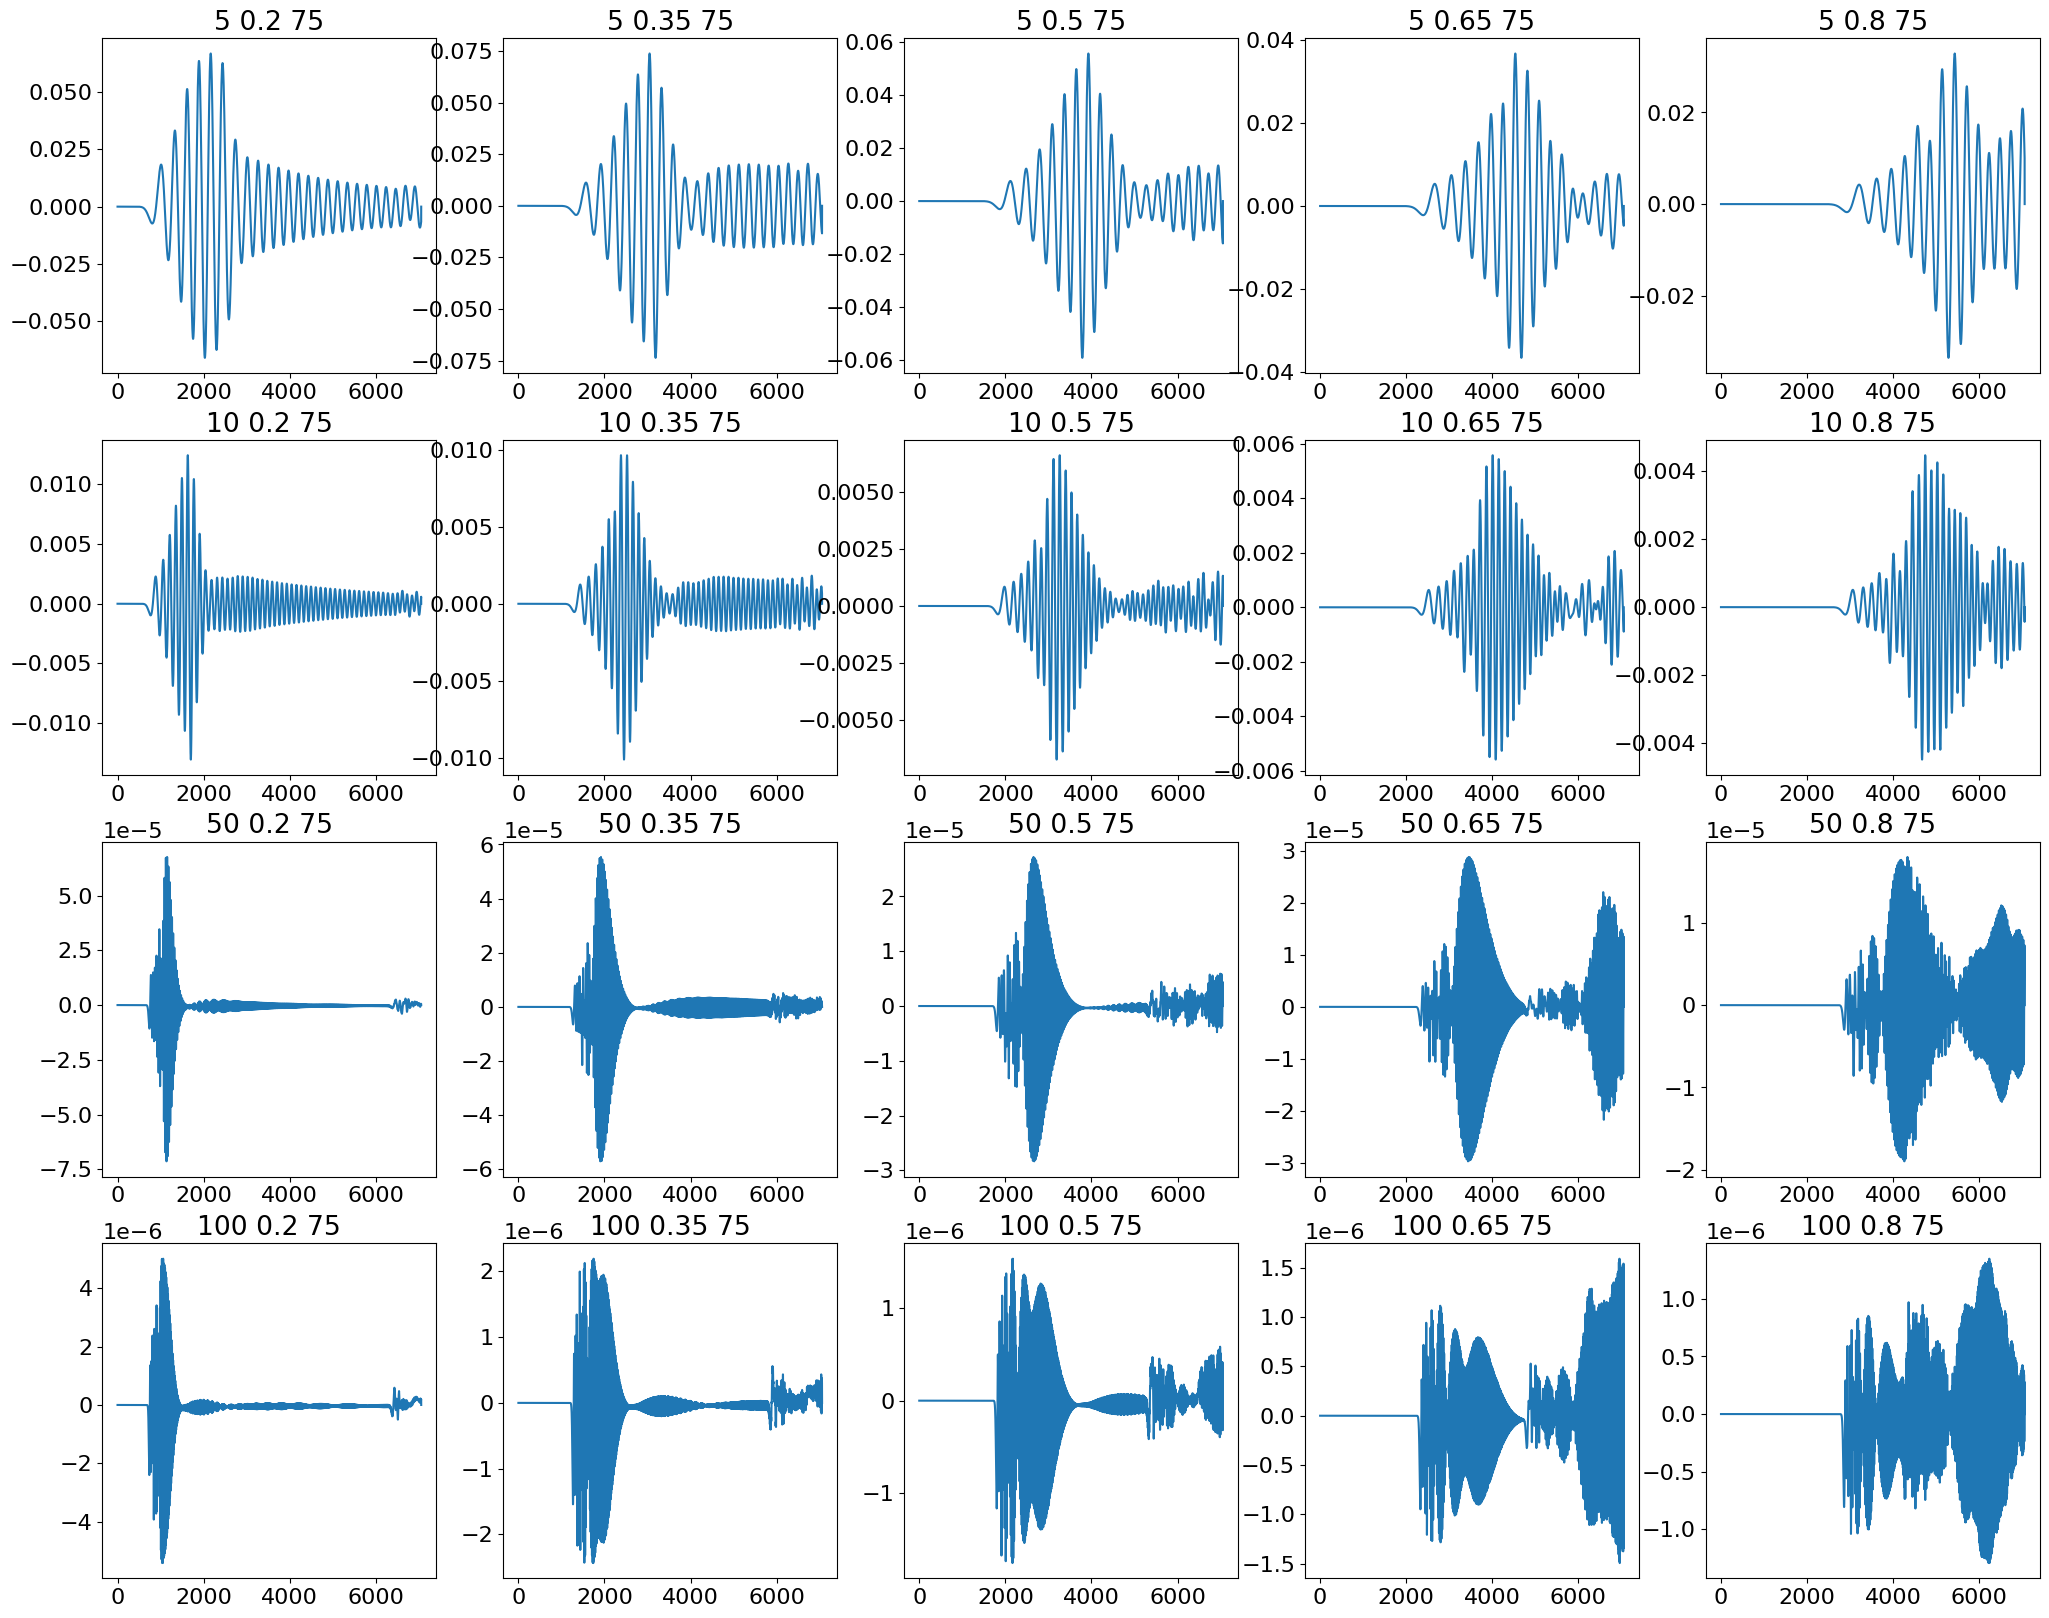

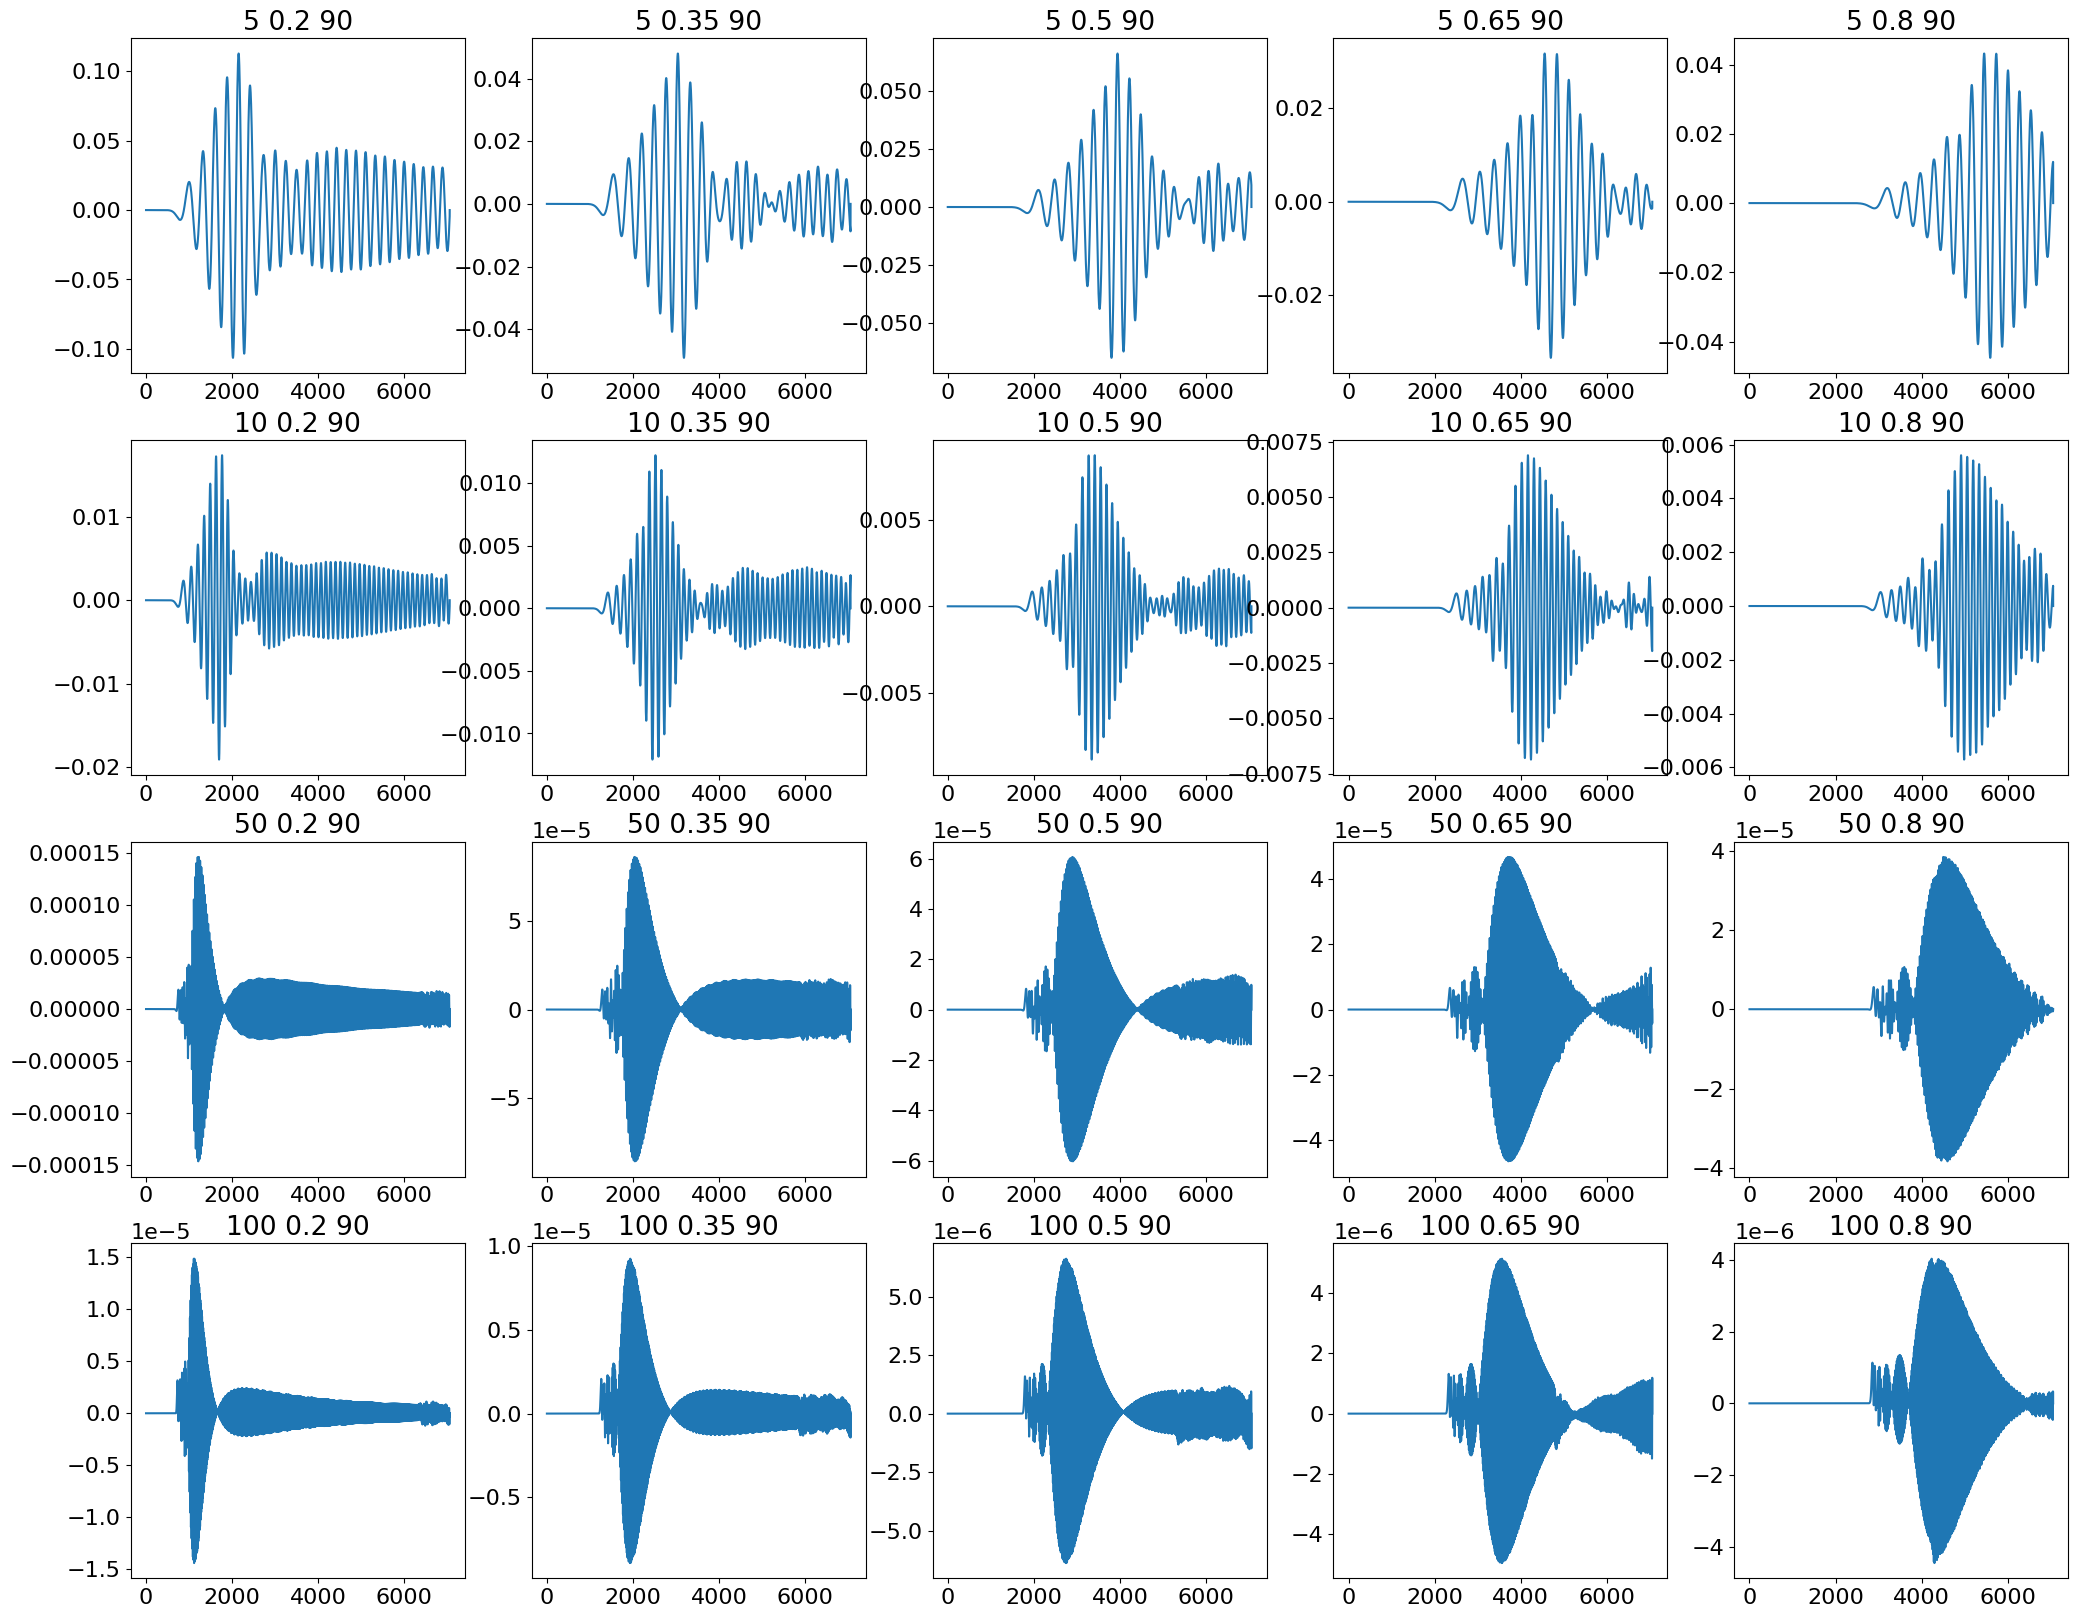

In [9]:
# center_freqs = [5, 10, 50, 100]
# distances = [.2, .35, .5, .65, .8]
# angles = [45, 60, 75, 90]
# for a in angles:
#     fig, ax = plt.subplots(len(center_freqs), len(distances), figsize=(25, 20))
#     for f in center_freqs:
#         for d in distances:
#             print(f"Running {f} {d} {a}")
#             start_time = time.time()
#             recording, _ = get_ideal_signal(domain_size, f, v_env, source_distance, ns, d, a, dt, plot=False)
#             print(f"Time: {time.time() - start_time}")
#             with open(f"./data/{domain_size[0]}x{domain_size[1]}/{f}_{d}_{a}.npy", "wb") as out:
#                 np.save(out, recording)
#             # with open(f"./data/{f}_{d}_{a}_snap.npy", "wb") as out:
#             #     np.save(out, snap)
#             ax[center_freqs.index(f), distances.index(d)].plot(recording)
#             ax[center_freqs.index(f), distances.index(d)].set_title(f"{f} {d} {a}")

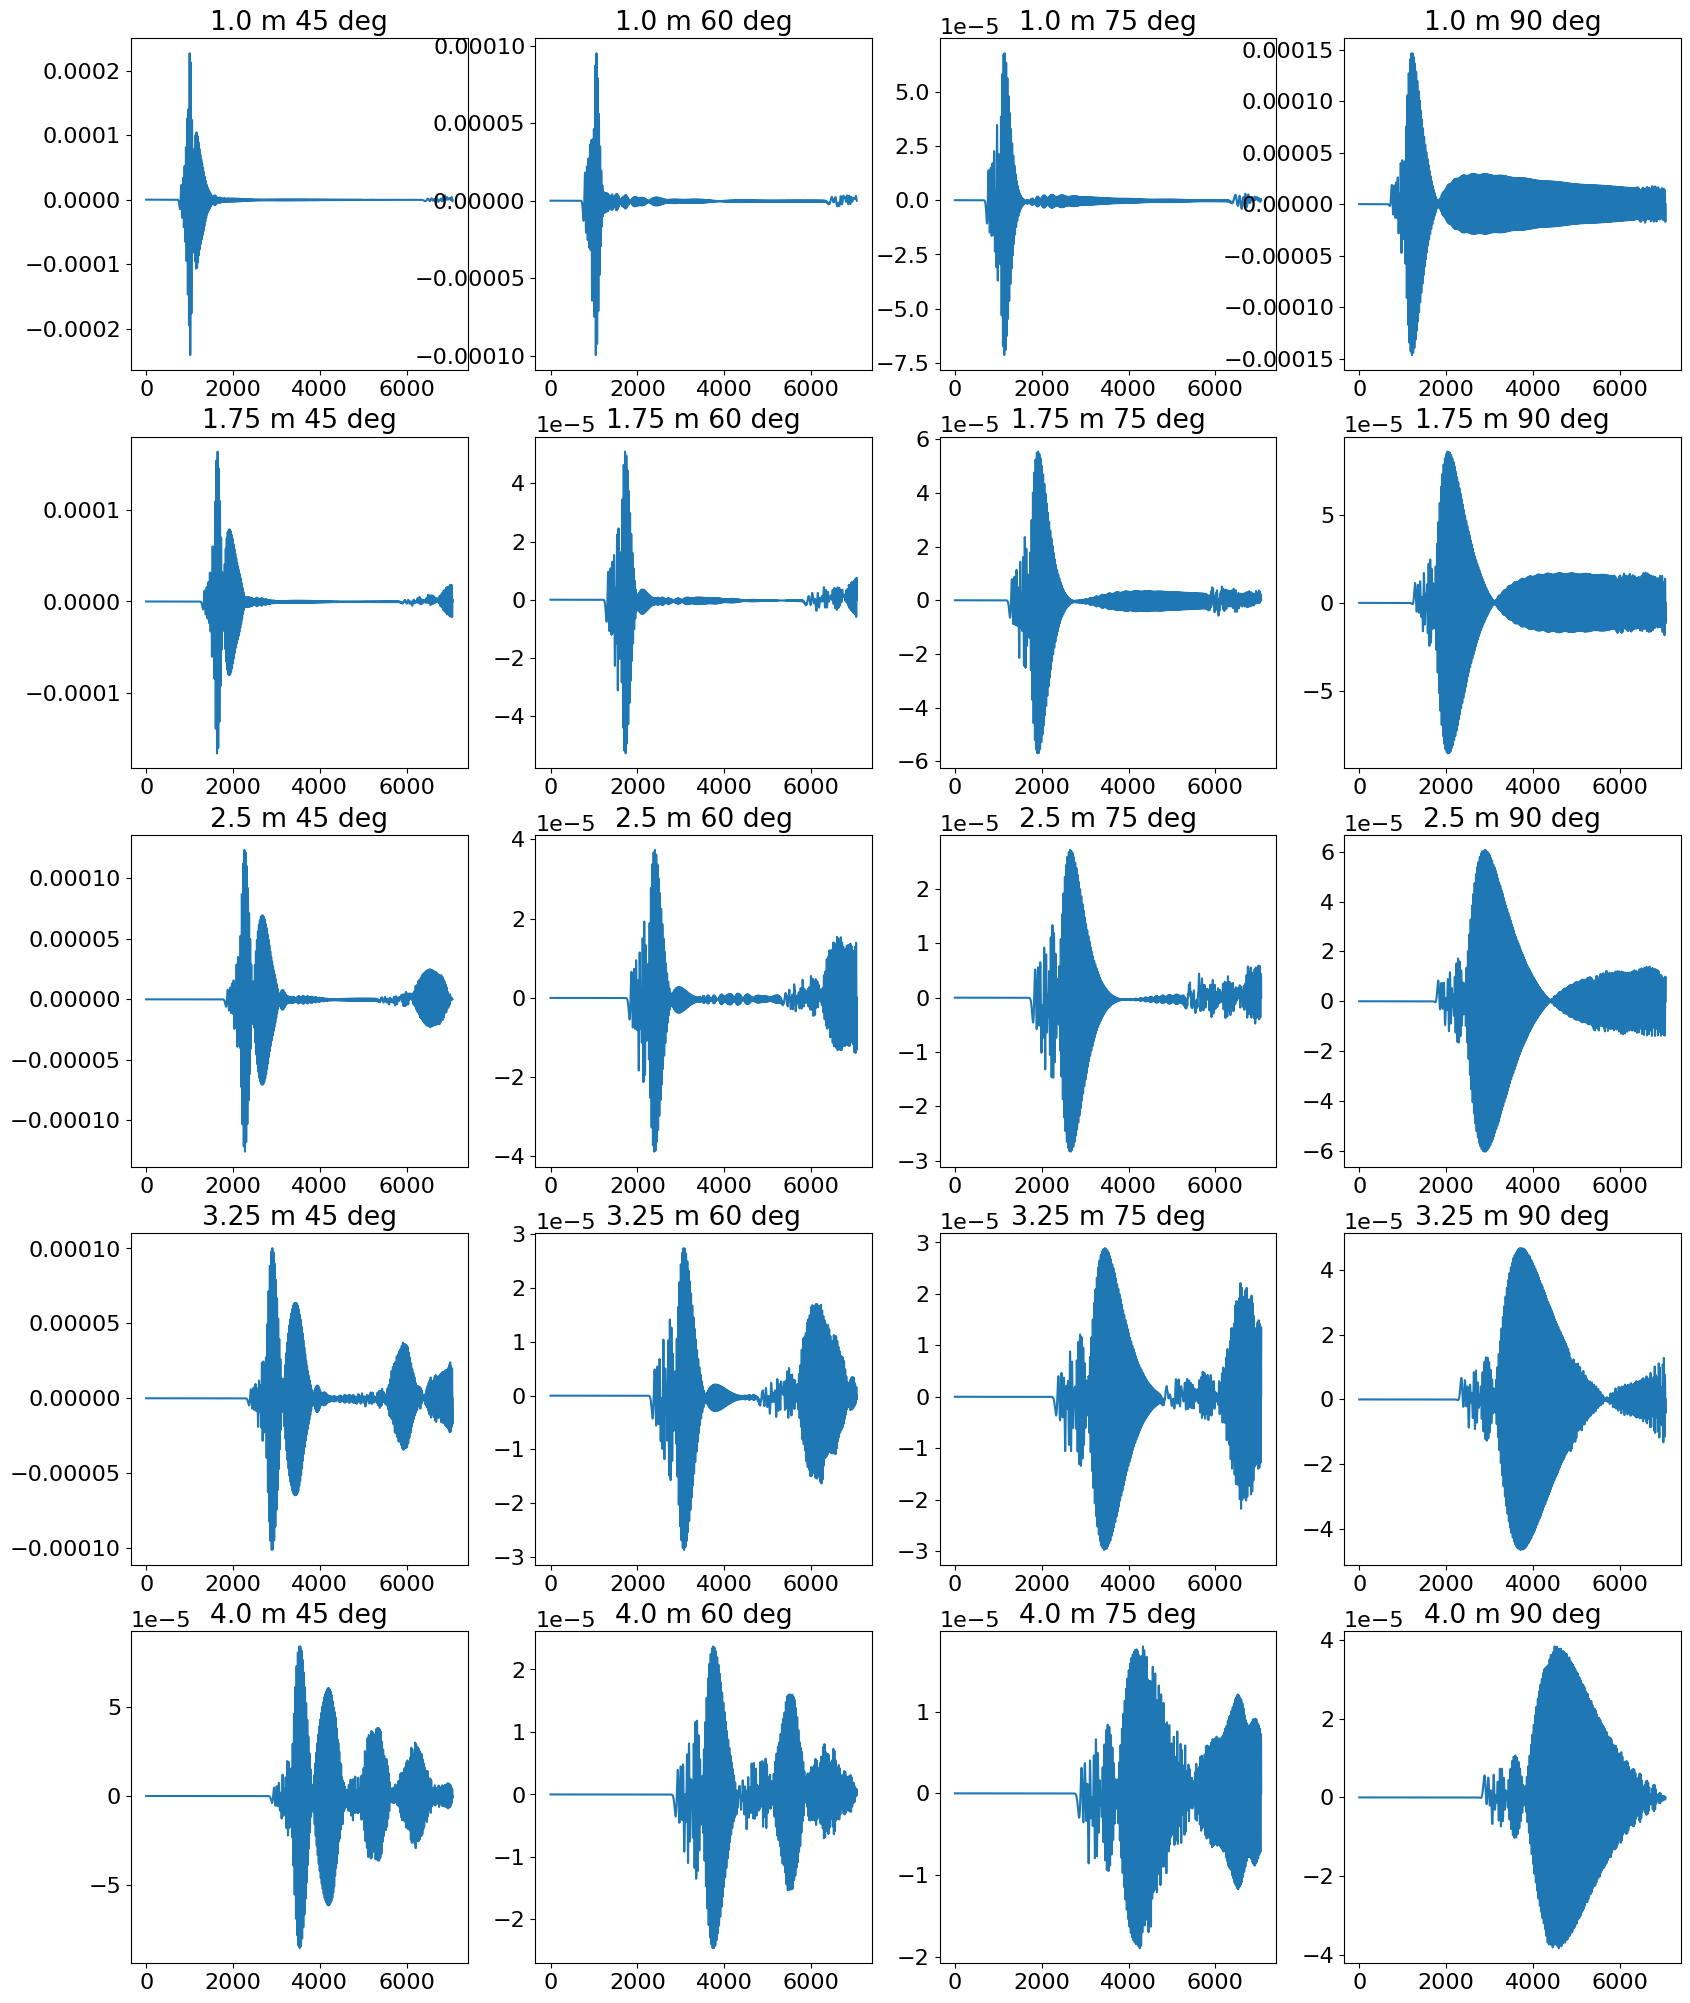

In [7]:
distances = [.2, .35, .5, .65, .8]
angles = [45, 60, 75, 90]
recordings_50 = {d: {a: [] for a in angles} for d in distances}
fig, ax = plt.subplots(5, 4, figsize=(20, 25))
for d in distances:
    for a in angles:
        with open(f"./data/{domain_size[0]}x{domain_size[1]}/50_{d}_{a}.npy", "rb") as f:
            recordings_50[d][a] = np.load(f)
        ax[distances.index(d), angles.index(a)].plot(recordings_50[d][a])
        ax[distances.index(d), angles.index(a)].set_title(f"{d * domain_size[1] / 2} m {a} deg")

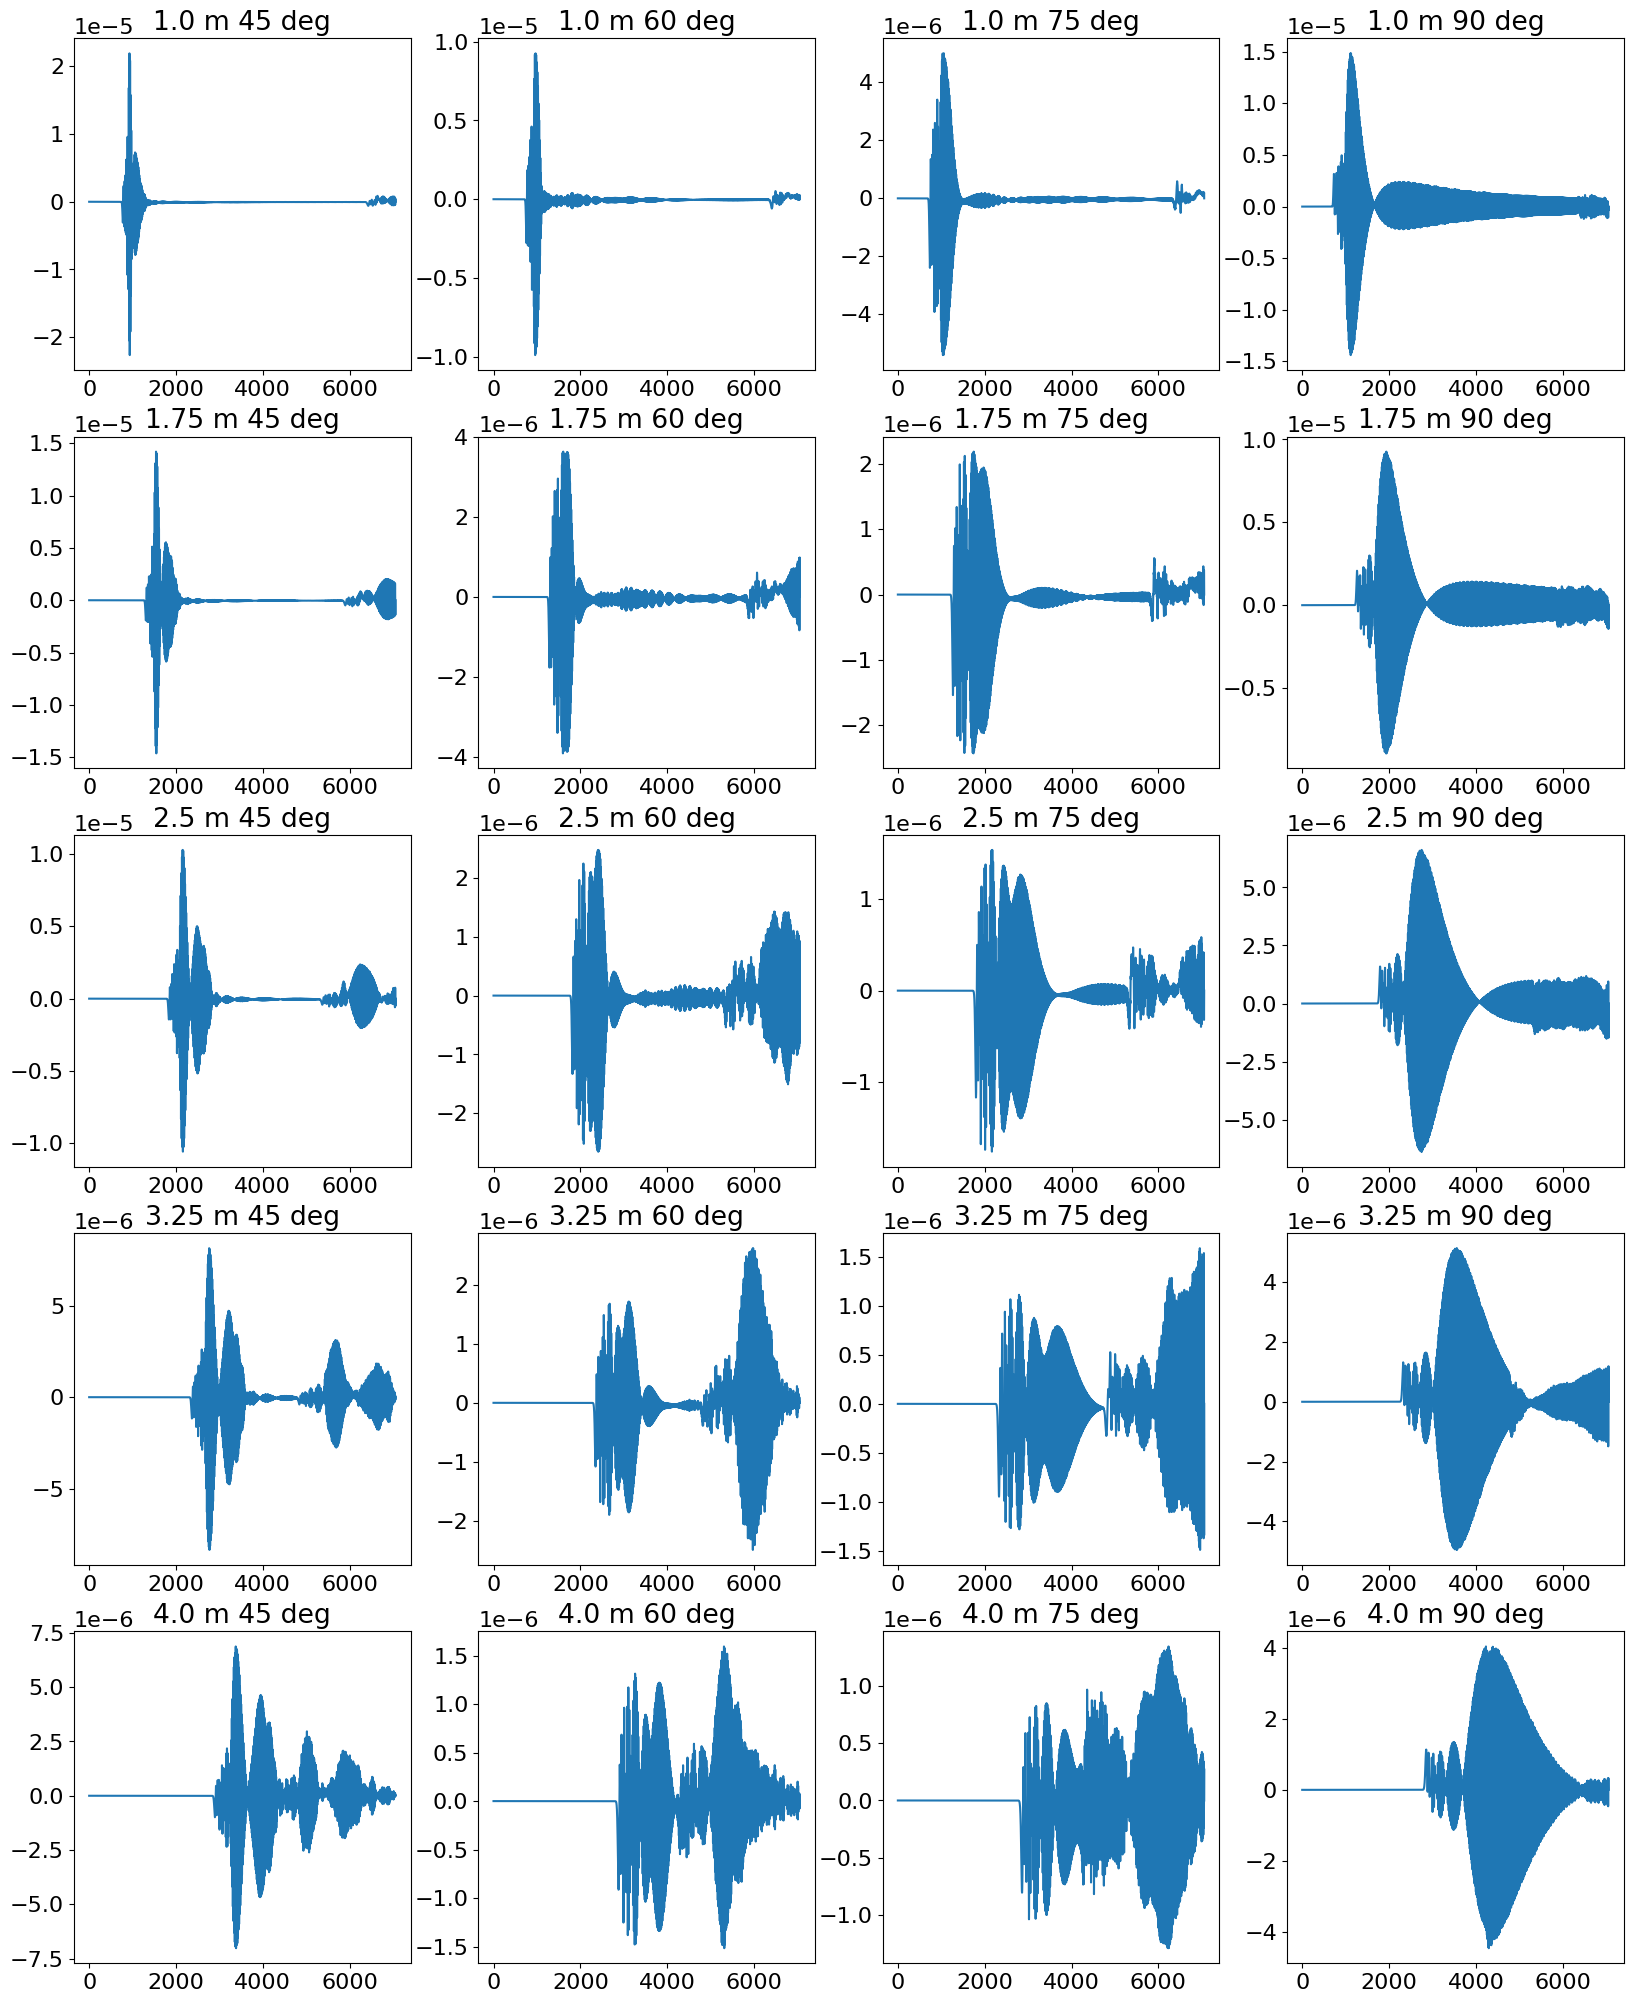

In [8]:
distances = [.2, .35, .5, .65, .8]
angles = [45, 60, 75, 90]
recordings_100 = {d: {a: [] for a in angles} for d in distances}
fig, ax = plt.subplots(5, 4, figsize=(20, 25))
for d in distances:
    for a in angles:
        with open(f"./data/{domain_size[0]}x{domain_size[1]}/100_{d}_{a}.npy", "rb") as f:
            recordings_100[d][a] = np.load(f)
        ax[distances.index(d), angles.index(a)].plot(recordings_100[d][a])
        ax[distances.index(d), angles.index(a)].set_title(f"{d * domain_size[1] / 2} m {a} deg")

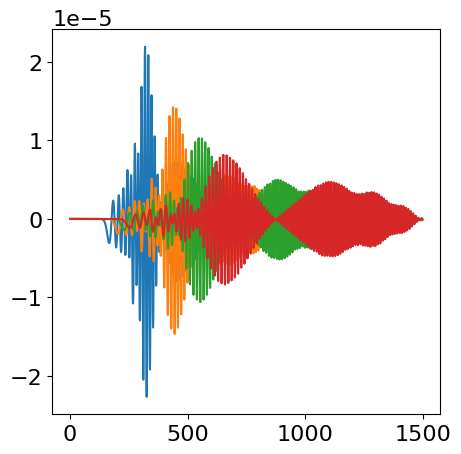

In [10]:
signal = recordings_100[.2][45]
first_index = np.where(signal != 0)[0][0]
plt.plot(signal[first_index:first_index+1500])
signal_2 = recordings_100[.35][45]
first_index_2 = np.where(signal_2 != 0)[0][0]
plt.plot(signal_2[first_index_2:first_index_2+1500])
signal_3 = recordings_100[.5][45]
first_index_3 = np.where(signal_3 != 0)[0][0]
plt.plot(signal_3[first_index_3:first_index_3+1500])
signal_4 = recordings_100[.65][45]
first_index_4 = np.where(signal_4 != 0)[0][0]
plt.plot(signal_4[first_index_4:first_index_4+1500])

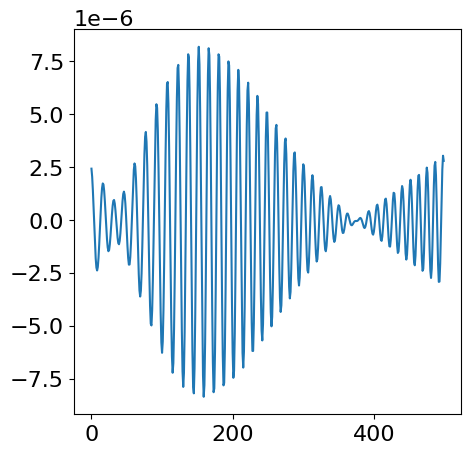

In [11]:
plt.plot(signal_4[first_index_4+500:first_index_4+1000])